# 📊 03 - Modelagem

## 0. Configuração Inicial

In [35]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
sys.path.append(os.path.abspath('../models'))

import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from isolation_forest import isoforest
from local_outlier_factor import lof
from autoencoders import AutoencoderFraude

Carregando os dados de treino e teste novamente

In [2]:
x_train = pd.read_csv('../data/processed/creditcard_train.csv')
x_test = pd.read_csv('../data/processed/creditcard_test.csv')
y_test = pd.read_csv('../data/processed/creditcard_test_label.csv')

print(f"Treino carregado: {x_train.shape}")
print(f"Teste carregado: {x_test.shape}")

Treino carregado: (226602, 31)
Teste carregado: (57124, 31)


In [3]:
def plot_confusion_matrix(y_pred, title):
    cm = confusion_matrix(y_test.iloc[:, 0], y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
    plt.title(label=title)
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.show()

## 1. Isolation Forest

In [4]:
iso_forest, y_pred = isoforest(x_train, x_test, 100, 'auto', 'auto')


          --- Relatório de Classificação ---
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     56651
      Fraude       0.15      0.82      0.26       473

    accuracy                           0.96     57124
   macro avg       0.57      0.89      0.62     57124
weighted avg       0.99      0.96      0.97     57124



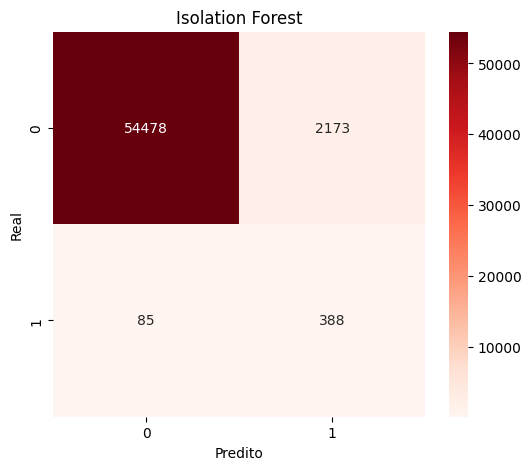

In [5]:
print("\n          --- Relatório de Classificação ---")
print(classification_report(y_test.iloc[:, 0], y_pred, target_names=['Normal', 'Fraude']))

plot_confusion_matrix(y_pred, "Isolation Forest")

## 2. Local Outlier Factor (Lof)

In [6]:
lof, y_pred = lof(x_train, x_test, 100, 'minkowski', 'auto')


          --- Relatório de Classificação ---
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     56651
      Fraude       0.23      0.84      0.36       473

    accuracy                           0.98     57124
   macro avg       0.61      0.91      0.67     57124
weighted avg       0.99      0.98      0.98     57124



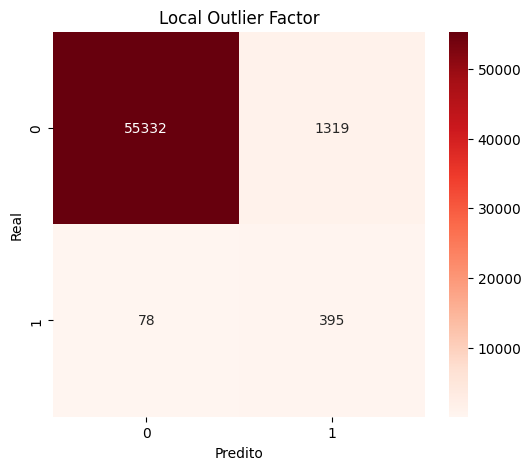

In [7]:
print("\n          --- Relatório de Classificação ---")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraude']))

plot_confusion_matrix(y_pred, "Local Outlier Factor")

## 3. Autoencoders (Deep Learning)

Nesta seção, utilizamos um **Autoencoder** para detecção de anomalias.
O modelo é treinado de maneira **semi-supervisionada**: ele aprende a reconstruir transações normais (`X_train`) com baixo erro. Quando exposto a fraudes (no `X_test`), espera-se que o erro de reconstrução seja significativamente maior, pois o modelo não aprendeu esses padrões atípicos.


Utils

In [8]:
# --- FUNÇÕES REUTILIZÁVEIS ---

def otimizar_threshold_f1(y_true, reconstruction_errors, steps=100, max_sigma=6):
   """
   Encontra o threshold que maximiza o F1-Score (Normal vs Fraude).
   Busca baseada na média e desvio padrão dos dados NORMAIS.
   """
   y_true = np.array(y_true).ravel()
   errors = np.array(reconstruction_errors).ravel()

   # Estatísticas apenas dos Normais
   normal_errors = errors[y_true == 0]
   mean_val = np.mean(normal_errors)
   std_val = np.std(normal_errors)

   # Range de busca: Média + [0 a max_sigma]*Std
   sigmas = np.linspace(0, max_sigma, steps)

   best_stats = {'f1': -1, 'threshold': 0, 'sigma': 0}
   history_f1 = []

   for sigma in sigmas:
       thresh = mean_val + sigma * std_val
       y_pred = (errors > thresh).astype(int)
       score = f1_score(y_true, y_pred, pos_label=1)
       history_f1.append(score)

       if score > best_stats['f1']:
           best_stats['f1'] = score
           best_stats['threshold'] = thresh
           best_stats['sigma'] = sigma

   return best_stats, sigmas, history_f1, mean_val, std_val

def plotar_analise_completa(y_true, errors, best_stats, sigmas, history_f1, mean_val, std_val):
   """Plota gráfico de otimização, scatter plot e matriz de confusão."""
   y_true = np.array(y_true).ravel()
   errors = np.array(errors).ravel()
   # 1. Gráfico de Otimização (F1 vs Threshold)
   thresholds_range = mean_val + sigmas * std_val

   plt.figure(figsize=(15, 5))

   plt.subplot(1, 3, 1)
   plt.plot(thresholds_range, history_f1, color='green', label='F1-Score')
   plt.axvline(best_stats['threshold'], color='red', linestyle='--', label='Melhor Threshold')
   plt.title(f"Maximização F1: {best_stats['f1']:.3f}")
   plt.xlabel('Threshold (MSE)')
   plt.ylabel('F1-Score')
   plt.legend()
   plt.grid(True, alpha=0.3)

   # 2. Scatter Plot (Normais vs Fraudes)
   plt.subplot(1, 3, 2)
   # Subsample para plotar mais rápido se for muito grande
   idx = np.arange(len(errors))
   plt.scatter(idx[y_true==0], errors[y_true==0], c='b', alpha=0.3, s=3, label='Normal')
   plt.scatter(idx[y_true==1], errors[y_true==1], c='r', marker='x', s=40, label='Fraude')
   plt.axhline(best_stats['threshold'], color='k', linestyle='--', label='Corte Otimizado')
   plt.title('Distribuição de Erros')
   plt.xlabel('Índice da Transação')
   plt.legend()

   # 3. Matriz de Confusão Computada com o Melhor Threshold
   y_pred_final = (errors > best_stats['threshold']).astype(int)
   cm = confusion_matrix(y_true, y_pred_final)

   plt.subplot(1, 3, 3)
   sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
               xticklabels=['Normal', 'Fraude'], yticklabels=['Normal', 'Fraude'])
   plt.title(f"Matriz Final\n(Thresh: {best_stats['threshold']:.3f})")
   plt.xlabel('Predito')
   plt.ylabel('Real')

   plt.tight_layout()
   plt.show()

   print("\nRelatório de Classificação (Melhor Threshold):")
   print(classification_report(y_true, y_pred_final, target_names=['Normal', 'Fraude']))


--- TREINAMENTO MODELO BASELINE ---

>>> Iniciando Treinamento do Autoencoder Baseline...
Epoch 1/50
2833/2833 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.5486 - val_loss: 0.4376 - learning_rate: 0.0010
Epoch 2/50
2833/2833 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3249 - val_loss: 0.2956 - learning_rate: 0.0010
Epoch 3/50
2833/2833 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2792 - val_loss: 0.2743 - learning_rate: 0.0010
Epoch 4/50
2833/2833 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2626 - val_loss: 0.2855 - learning_rate: 0.0010
Epoch 5/50
2833/2833 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2529 - val_loss: 0.2501 - learning_rate: 0.0010
Epoch 6/50
2833/2833 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2479 - val_loss: 0.2626 - learning_rate: 0.0010
Epoch 7/50
2833/2833 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2456 - val_loss: 0.2610 - learning_rate: 0.0010
Epoch 8/50
2819/2833 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2428
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2833/2833 ━━━━━━━━

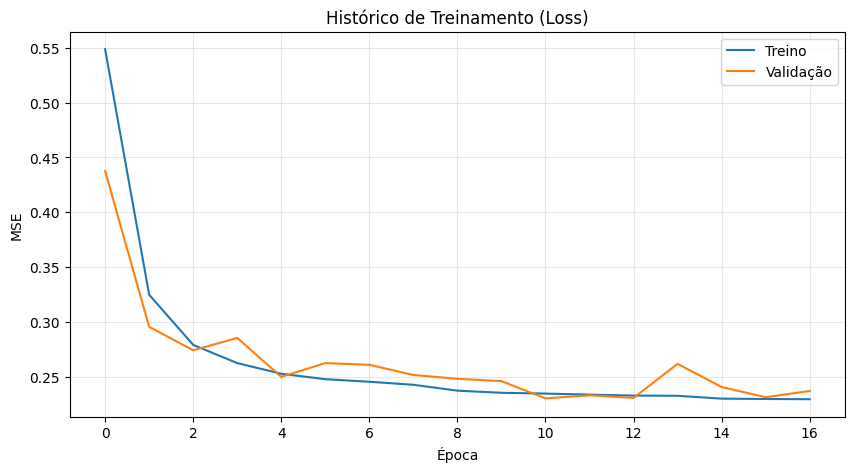

In [11]:
print(">>> Iniciando Treinamento do Autoencoder Baseline...")

input_dim = x_train.shape[1]

# Instancia Baseline 'Leve' (Sem L1 e sem Dropout para aprender rápido)
autoencoder_base = AutoencoderFraude(
   input_dim=input_dim,
   encoding_dim=14,
   dropout_rate=0.0,   # Desativado
   l1_reg=0.0,         # Desativado
   learning_rate=0.001
)

# Treina
hist = autoencoder_base.treinar(x_train, epochs=50, batch_size=64, verbose=1)

# Plota histórico
autoencoder_base.plotar_historico()

### 3.1. Avaliação do Erro de Reconstrução
Vamos calcular o erro de reconstrução (MSE) para o conjunto de teste e visualizar a diferença estatística entre transações normais e fraudulentas.


>>> Avaliando Baseline...

✅ Baseline Otimizado!
Melhor F1: 0.6533
Threshold: 3.2625


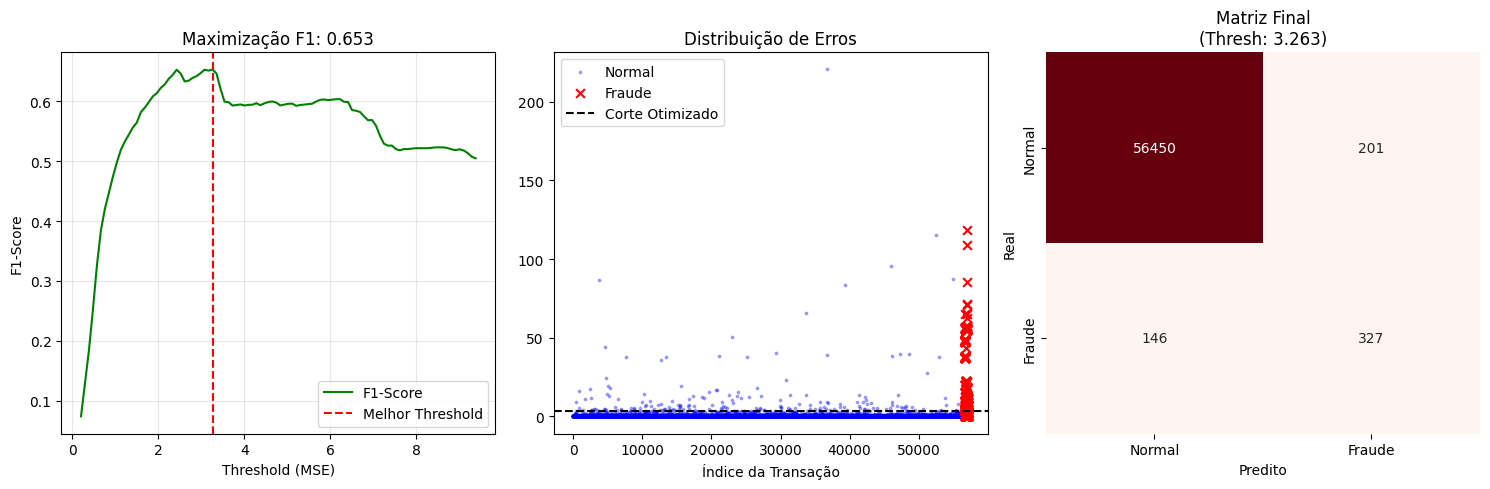


Relatório de Classificação (Melhor Threshold):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56651
      Fraude       0.62      0.69      0.65       473

    accuracy                           0.99     57124
   macro avg       0.81      0.84      0.83     57124
weighted avg       0.99      0.99      0.99     57124



In [ ]:
print(">>> Avaliando Baseline...")

# Calcula erros no conjunto de teste
errors_base = autoencoder_base.calcular_erro_reconstrucao(x_test)

# Otimiza Threshold usando nossa função DRY
# Retorna dicionário com melhores estatísticas e dados para plot
stats_base, sigmas, hist_f1, mean_v, std_v = otimizar_threshold_f1(y_test, errors_base)

print(f"\n✅ Baseline Otimizado!")
print(f"Melhor F1: {stats_base['f1']:.4f}")
print(f"Threshold: {stats_base['threshold']:.4f}")

# Plota tudo de uma vez
plotar_analise_completa(y_test, errors_base, stats_base, sigmas, hist_f1, mean_v, std_v)

## 4. Tunagem

### Isolation Forest

In [15]:
def objective(trial):
    # n_estimators: Quantas árvores na floresta
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    
    # max_samples: Quantas amostras usar para treinar cada árvore
    max_samples = trial.suggest_float('max_samples', 0.1, 1.0)
    
    # contamination: A proporção esperada de outliers no dataset.
    contamination = trial.suggest_float('contamination', 0.0001, 0.02)

    iso_forest, y_pred = isoforest(x_train, x_test, n_estimators, contamination, max_samples)
    
    # Avaliação com f1-score
    f1 = f1_score(y_test, y_pred)
    
    return f1

In [16]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2025-12-16 10:19:42,217] A new study created in memory with name: no-name-06ef8b7d-feff-4972-a693-d697a2f932c8
[I 2025-12-16 10:19:48,830] Trial 0 finished with value: 0.47384615384615386 and parameters: {'n_estimators': 150, 'max_samples': 0.3766477146149805, 'contamination': 0.013544735439852343}. Best is trial 0 with value: 0.47384615384615386.
[I 2025-12-16 10:20:04,314] Trial 1 finished with value: 0.41164021164021164 and parameters: {'n_estimators': 261, 'max_samples': 0.8378457929792213, 'contamination': 0.01827632190376479}. Best is trial 0 with value: 0.47384615384615386.
[I 2025-12-16 10:20:12,416] Trial 2 finished with value: 0.5320056899004267 and parameters: {'n_estimators': 139, 'max_samples': 0.7225132182619531, 'contamination': 0.00965013639424068}. Best is trial 2 with value: 0.5320056899004267.
[I 2025-12-16 10:20:25,588] Trial 3 finished with value: 0.4393241167434716 and parameters: {'n_estimators': 240, 'max_samples': 0.6240040675041899, 'contamination': 0.00057

In [17]:
print("------------------------------------------------")
print("Melhores parâmetros encontrados:")
print(study.best_params)
print(f"melhor f1 score: {study.best_value:.4f}")

------------------------------------------------
Melhores parâmetros encontrados:
{'n_estimators': 292, 'max_samples': 0.6235896948448042, 'contamination': 0.00335907679995248}
melhor f1 score: 0.6201


Estatisticas do melhor modelo

In [18]:
best_model_if = IsolationForest(**study.best_params, random_state=42, n_jobs=-1)
best_model_if.fit(x_train)

y_pred_raw = best_model_if.predict(x_test)
y_pred = [1 if x == -1 else 0 for x in y_pred_raw]


          --- Relatório de Classificação ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56651
      Fraude       0.62      0.62      0.62       473

    accuracy                           0.99     57124
   macro avg       0.81      0.81      0.81     57124
weighted avg       0.99      0.99      0.99     57124



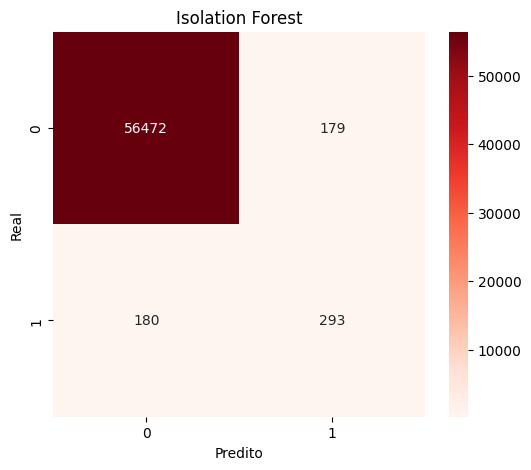

In [19]:
print("\n          --- Relatório de Classificação ---")
print(classification_report(y_test.iloc[:, 0], y_pred, target_names=['Normal', 'Fraude']))

plot_confusion_matrix(y_pred, "Isolation Forest")

### Local Outlier Factor

In [28]:
def objective(trial):  
    n_neighbors = trial.suggest_int('n_neighbors', 10, 100)
    
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    
    # contamination: Define o limiar de decisão
    contamination = trial.suggest_float('contamination', 0.0001, 0.02)

    model, y_pred = lof(x_train, x_test, n_neighbors, metric, contamination)
    
    # Avaliação com f1-score
    f1 = f1_score(y_test, y_pred)
    
    return f1

In [29]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, timeout=1800)

[I 2025-12-16 10:40:31,639] A new study created in memory with name: no-name-e9aa0f74-d52b-465c-bda3-5ff7868752ff
[I 2025-12-16 10:41:36,856] Trial 0 finished with value: 0.4076963078523141 and parameters: {'n_neighbors': 95, 'metric': 'minkowski', 'contamination': 0.018653818759576186}. Best is trial 0 with value: 0.4076963078523141.
[I 2025-12-16 10:45:51,476] Trial 1 finished with value: 0.0884450784593438 and parameters: {'n_neighbors': 16, 'metric': 'manhattan', 'contamination': 0.015312472150441054}. Best is trial 0 with value: 0.4076963078523141.
[I 2025-12-16 10:49:50,944] Trial 2 finished with value: 0.5174825174825175 and parameters: {'n_neighbors': 86, 'metric': 'manhattan', 'contamination': 0.009653515714502847}. Best is trial 2 with value: 0.5174825174825175.
[I 2025-12-16 10:50:45,163] Trial 3 finished with value: 0.3902439024390244 and parameters: {'n_neighbors': 43, 'metric': 'euclidean', 'contamination': 0.010320960450372665}. Best is trial 2 with value: 0.517482517482

In [30]:
print("------------------------------------------------")
print("Melhores parâmetros:")
print(study.best_params)
print(f"Melhor f1-score: {study.best_value:.4f}")

------------------------------------------------
Melhores parâmetros:
{'n_neighbors': 73, 'metric': 'minkowski', 'contamination': 0.004216846306757041}
Melhor f1-score: 0.6909


Estatisticas do melhor modelo

In [31]:
best_model_lof = LocalOutlierFactor(**study.best_params, novelty=True, n_jobs=-1)
best_model_lof.fit(x_train)

y_pred_raw = best_model_lof.predict(x_test)
y_pred = [1 if x == -1 else 0 for x in y_pred_raw]


          --- Relatório de Classificação ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56651
      Fraude       0.62      0.78      0.69       473

    accuracy                           0.99     57124
   macro avg       0.81      0.89      0.84     57124
weighted avg       1.00      0.99      0.99     57124



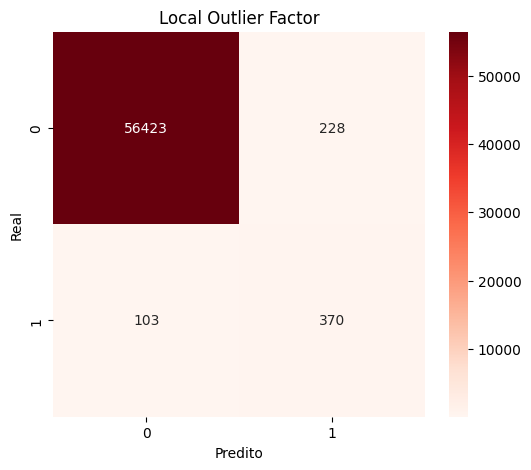

In [32]:
print("\n          --- Relatório de Classificação ---")
print(classification_report(y_test.iloc[:, 0], y_pred, target_names=['Normal', 'Fraude']))

plot_confusion_matrix(y_pred, "Local Outlier Factor")

### Autoencoders

In [ ]:
def objective_tuning(trial):
   tf.keras.backend.clear_session() # Limpa memória

   # 1. Sugestão de Hiperparâmetros
   params = {
       'input_dim': x_train.shape[1],
       'encoding_dim': trial.suggest_int('encoding_dim', 8, 20),
       'num_layers': trial.suggest_int('num_layers', 1, 3),
       'neurons_decay': trial.suggest_float('neurons_decay', 0.4, 0.9),
       'activation': trial.suggest_categorical('activation', ['elu', 'relu', 'swish', 'tanh']),
       'dropout_rate': trial.suggest_float('dropout_rate', 0.0, 0.3),
       'l1_reg': trial.suggest_float('l1_reg', 1e-6, 1e-3, log=True),
       'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
   }
   batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])

   # 2. Treina (Rápido)
   model = AutoencoderFraude(**params)
   try:
       model.treinar(x_train, epochs=20, batch_size=batch_size, verbose=0)
   except:
       return 0.0 # Poda em caso de erro matemático

   # 3. Avalia Potencial (Reutilizando lógica DRY)
   errors = model.calcular_erro_reconstrucao(x_test)
   # Busca rápida (apenas 30 steps para ser veloz)
   bst, _, _, _, _ = otimizar_threshold_f1(y_test, errors, steps=30)

   return bst['f1']

print(">>> Iniciando Busca Optuna (50 Trials)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective_tuning, n_trials=50, timeout=3600)

print("\n🏆 MELHORES PARÂMETROS:", study.best_params)
print(f"Melhor F1 (Tuning): {study.best_value:.4f}")

[I 2025-12-16 11:15:21,388] A new study created in memory with name: no-name-e2933fee-fbbb-40ea-8762-e56e8e59a529


>>> Iniciando Busca Optuna (50 Trials)...



[I 2025-12-16 11:16:27,193] Trial 0 finished with value: 0.6337371854613234 and parameters: {'encoding_dim': 18, 'num_layers': 1, 'neurons_decay': 0.5722359822726566, 'activation': 'tanh', 'dropout_rate': 0.16912640643886578, 'l1_reg': 5.152376043442704e-06, 'learning_rate': 0.005541054557099396, 'batch_size': 64}. Best is trial 0 with value: 0.6337371854613234.
[I 2025-12-16 11:17:41,398] Trial 1 finished with value: 0.7634854771784232 and parameters: {'encoding_dim': 19, 'num_layers': 1, 'neurons_decay': 0.44409659827294695, 'activation': 'tanh', 'dropout_rate': 0.0685335654970577, 'l1_reg': 3.5236688656827817e-06, 'learning_rate': 0.0002346513288197182, 'batch_size': 64}. Best is trial 1 with value: 0.7634854771784232.
[I 2025-12-16 11:18:13,680] Trial 2 finished with value: 0.6727772685609532 and parameters: {'encoding_dim': 14, 'num_layers': 2, 'neurons_decay': 0.44926178502321173, 'activation': 'tanh', 'dropout_rate': 0.035286170773155, 'l1_reg': 0.00010418973721105093, 'learning


🏆 MELHORES PARÂMETROS: {'encoding_dim': 20, 'num_layers': 1, 'neurons_decay': 0.40127394475995487, 'activation': 'tanh', 'dropout_rate': 0.07798243979259545, 'l1_reg': 0.00020584077663130546, 'learning_rate': 0.00013683825135163343, 'batch_size': 256}
Melhor F1 (Tuning): 0.8389


>>> Treinando Modelo Final Robusto...
Epoch 1/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.9735 - val_loss: 1.5679 - learning_rate: 1.3684e-04
Epoch 2/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2975 - val_loss: 1.1311 - learning_rate: 1.3684e-04
Epoch 3/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9887 - val_loss: 0.8827 - learning_rate: 1.3684e-04
Epoch 4/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7972 - val_loss: 0.7274 - learning_rate: 1.3684e-04
Epoch 5/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6725 - val_loss: 0.6223 - learning_rate: 1.3684e-04
Epoch 6/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5881 - val_loss: 0.5473 - learning_rate: 1.3684e-04
Epoch 7/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5240 - val_loss: 0.4849 - learning_rate: 1.3684e-04
Epoch 8/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4731 - val_loss: 0.4346 - learning_rate: 1.3684e-04
Epoch 9/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 1

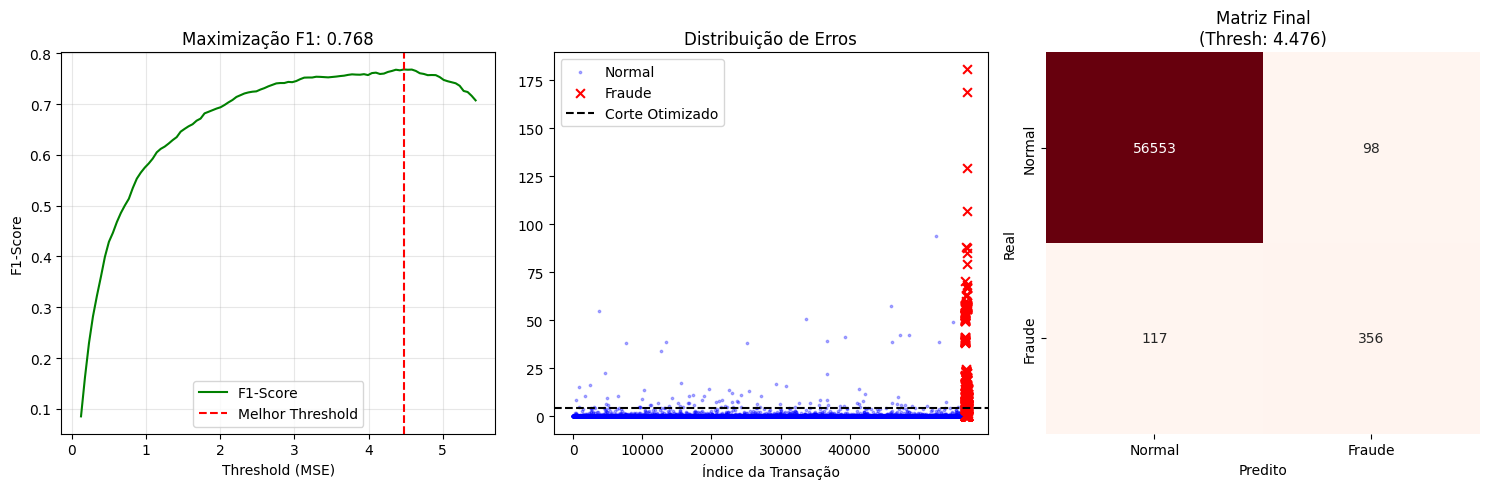


Relatório de Classificação (Melhor Threshold):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56651
      Fraude       0.78      0.75      0.77       473

    accuracy                           1.00     57124
   macro avg       0.89      0.88      0.88     57124
weighted avg       1.00      1.00      1.00     57124



In [ ]:
print(">>> Treinando Modelo Final Robusto...")

# Prepara parâmetros
final_params = study.best_params.copy()
final_batch = final_params.pop('batch_size', 128)
final_params['input_dim'] = x_train.shape[1]

# Treina pra valer
final_model = AutoencoderFraude(**final_params)
final_model.treinar(x_train, epochs=100, batch_size=final_batch, verbose=1)

# Avalia
final_errors = final_model.calcular_erro_reconstrucao(x_test)

# Otimização Fina (100 steps)
stats_final, sigmas_f, hist_f_final, mv_f, sv_f = otimizar_threshold_f1(y_test, final_errors, steps=100)

print(f"\n🚀 RESULTADO FINAL APÓS TUNING")
print(f"Ref F1 (Baseline): {stats_base['f1']:.4f}")
print(f"Novo F1 (Final):   {stats_final['f1']:.4f}")

# Gráficos Finais
plotar_analise_completa(y_test, final_errors, stats_final, sigmas_f, hist_f_final, mv_f, sv_f)

## 5. Comparação de Resultados

In [45]:
# Função para garantir formato correto dos labels
def get_clean_y_true(y):
    return np.array(y).ravel()

y_true = get_clean_y_true(y_test)

# Função auxiliar para calcular métricas de forma padronizada
def get_metrics(y_true, y_pred, model_name):
    return {
        'Modelo': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }
    
metrics_list = []

In [46]:
print("1. Avaliando Isolation Forest...")
y_pred_if_raw = best_model_if.predict(x_test)

y_pred_if = [1 if x == -1 else 0 for x in y_pred_if_raw]
metrics_list.append(get_metrics(y_true, y_pred_if, 'Isolation Forest'))

print("2. Avaliando Local Outlier Factor...")
y_pred_lof_raw = best_model_lof.predict(x_test)
y_pred_lof = [1 if x == -1 else 0 for x in y_pred_lof_raw]
metrics_list.append(get_metrics(y_true, y_pred_lof, 'Local Outlier Factor'))

print("3. Avaliando Autoencoder...")
y_pred_final = (final_errors > stats_final['threshold']).astype(int)
metrics_list.append(get_metrics(y_true, y_pred_final, 'Autoencoder'))

1. Avaliando Isolation Forest...
2. Avaliando Local Outlier Factor...
3. Avaliando Autoencoder...



🏆 TABELA DE RESULTADOS FINAIS
                      Accuracy  Precision  Recall  F1-Score
Modelo                                                     
Isolation Forest        0.9937     0.6208  0.6195    0.6201
Local Outlier Factor    0.9942     0.6187  0.7822    0.6909
Autoencoder             0.9962     0.7841  0.7526    0.7681


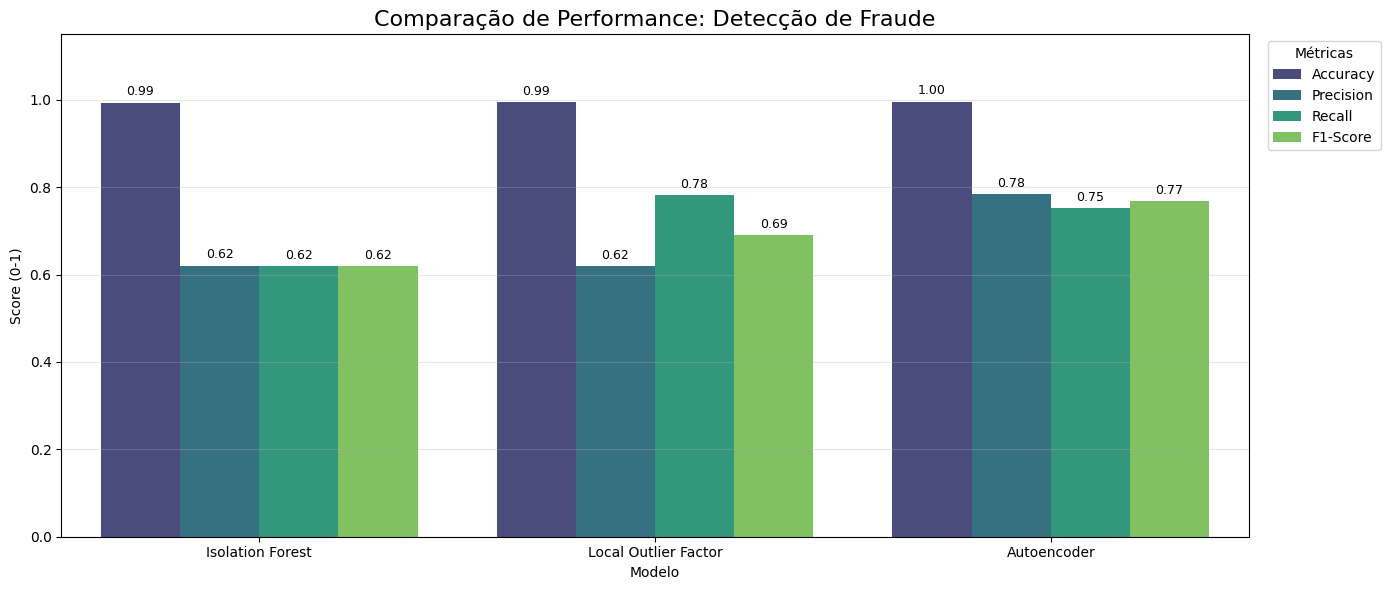

In [44]:
df_results = pd.DataFrame(metrics_list).set_index('Modelo')

print("\n" + "="*60)
print("🏆 TABELA DE RESULTADOS FINAIS")
print("="*60)
print(df_results.round(4))
print("="*60)

# Gráfico Comparativo
plt.figure(figsize=(14, 6))

# Transformar para formato longo para facilitar o plot com Seaborn
df_melted = df_results.reset_index().melt(id_vars='Modelo', var_name='Métrica', value_name='Score')

# Plot
ax = sns.barplot(data=df_melted, x='Modelo', y='Score', hue='Métrica', palette='viridis')

plt.title('Comparação de Performance: Detecção de Fraude', fontsize=16)
plt.ylabel('Score (0-1)')
plt.ylim(0, 1.15) # Espaço extra para legenda
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title='Métricas')
plt.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

plt.tight_layout()
plt.show()

O isolation forest teve uma boa precisão, mas falhou em detectar uma quantidade significativa de fraudes (baixo recall), já o Local Outlier Factor teve um precision baixo, porém foi o modelo que mais conseguiu detectar fraudes (alto recall), O melhor modelo foi o autoencoder poís conseguiu balancear bem as métricas, tendo a maior precisão e maior F1-Score que os outros.